In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__'))

project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.utils import load_image, apply, display_image, display_image_comparison, rgb_to_grayscale

# Chapter 4: Histograms and Equalization

The **histogram** of an image is a graphical representation that shows the distribution of pixel intensity values in the image. It provides a summary of how many pixels are at each intensity level across the image.

The shape of an image's histogram can indicate certain characteristics of an image like brightness, contrast, and exposure. In later chapters the hostogram of an image is even used to identify objects from background using *segmentation* algorithms (*see chapter 9*).

## Histogram Generation Algorithm

Let:
-  $\mathbf{I}$: Input image
-  $L = 256$: Number of possible intensity levels
-  $\mathbf{h}[k]$: Count of pixels at intensity $k$ ($k \in [0, L-1]$).

For an image $\mathbf{I}$ of size $m \times n$:

1. Set $\mathbf{h}[k] = 0 \quad \forall k \in [0, L-1]$
2. For each pixel $[x,y] \in \mathbf{I}$:
    1. Let $p = \mathbf{I}[x,y]$
    2. Update the histogram:
       $$
           \mathbf{h}[p] = \mathbf{h}[p] + 1
       $$

### Implementation

In [2]:
import numpy as np

In [3]:
def generate_histogram(I: np.ndarray) -> np.ndarray:
    m, n = I.shape
    
    h = np.zeros(256, dtype=np.uint64)

    for y in range(m):
        for x in range(n):
            p = I[y,x]
            h[p] += 1

    return h

Numpy also has a built-in function to calculate histograms, which is much more optimized that the implementation above.

In [4]:
def generate_histogram_numpy(I: np.ndarray) -> np.ndarray:
    histogram, _ = np.histogram(I, bins=256, range=(0, 255))
    return histogram

We'll also need a function to display the histogram for an image. We already have a `display_image` function in `utils.py`, we can modify this function to also include the histogram.

In [5]:
import matplotlib.pyplot as plt
from typing import Tuple
from PIL import Image

In [6]:
def display_image_with_histogram(image: Image.Image, histogram: np.ndarray,  title: str = 'Image', hist_title: str = 'Histogram', figsize: Tuple[int, int] = (8, 10)) -> None:
    try:
        fig, (ax_image, ax_hist) = plt.subplots(
            2, 1, 
            figsize=figsize, 
            gridspec_kw={'height_ratios': [5, 1]},
            sharex=False
        )

        if image.mode == 'L':
            ax_image.imshow(image, cmap='gray')
        else:
            ax_image.imshow(image)
        ax_image.set_title(title)
        ax_image.axis('off')

        ax_hist.bar(range(len(histogram)), histogram, width=1, color='gray')
        ax_hist.set_title(hist_title)
        ax_hist.set_xlim([0, 255])
        ax_hist.set_xlabel('Intensity Value')
        ax_hist.set_ylabel('Pixel Count')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

    except Exception as e:
        print(f"Error displaying image and histogram: {e}")

We should also modify the `display_image_comparison` function.

In [7]:
def display_image_comparison_with_histogram(image_1: Image.Image, histogram_1: np.ndarray, image_2: Image.Image, histogram_2: np.ndarray, title_1: str = 'Image 1',
                                            hist_title_1: str = 'Histogram 1', title_2: str = 'Image 2', hist_title_2: str = 'Histogram 2', 
                                            figsize: Tuple[int, int] = (16, 10)) -> None:
    try:
        fig, axes = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'height_ratios': [5, 1]})
        
        ax = axes[0, 0]
        if image_1.mode == 'L':
            ax.imshow(image_1, cmap='gray')
        else:
            ax.imshow(image_1)
        ax.set_title(title_1)
        ax.axis('off') 
        
        ax = axes[0, 1]
        if image_2.mode == 'L':
            ax.imshow(image_2, cmap='gray')
        else:
            ax.imshow(image_2)
        ax.set_title(title_2)
        ax.axis('off')
        
        ax = axes[1, 0]
        ax.bar(range(len(histogram_1)), histogram_1, width=1, color='gray')
        ax.set_title(hist_title_1)
        ax.set_xlim([0, 255])
        ax.set_xlabel('Intensity Value')
        ax.set_ylabel('Pixel Count')
        
        ax = axes[1, 1]
        ax.bar(range(len(histogram_2)), histogram_2, width=1, color='gray')
        ax.set_title(hist_title_2)
        ax.set_xlim([0, 255])
        ax.set_xlabel('Intensity Value')
        ax.set_ylabel('Pixel Count')
        
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    
    except Exception as e:
        print(f"Error displaying image comparison with histograms: {e}")

### Examples

#### Example 1 

In [8]:
image_1_path = "../TEST-IMAGES/OLD-CLASSIC/man.pgm"
image_1 = load_image(image_1_path)

Image Metadata for 'man.pgm':
 - Format: PPM
 - Size on Disk: 1024.02 KB
 - Dimensions: 1024x1024 pixels
 - Mode: L
 - Channels: 1


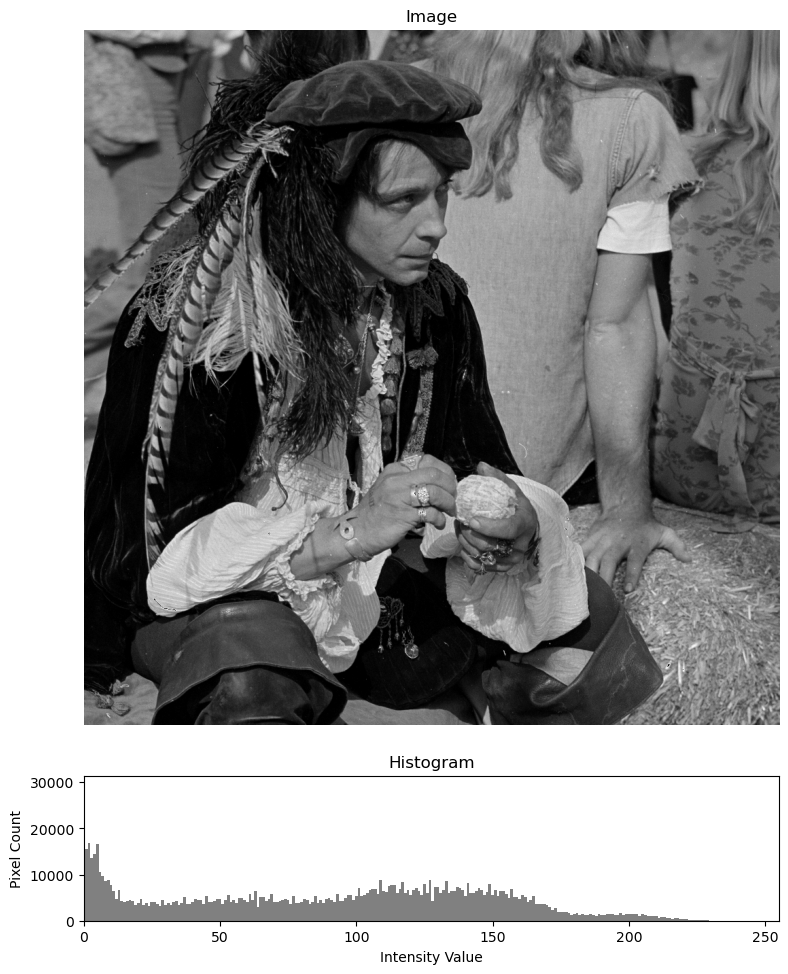

In [9]:
image_1_histogram = apply(image_1, generate_histogram, return_array=True)
display_image_with_histogram(image_1, image_1_histogram)

Let's use this example to compare between the speed of the two implementations we wrote for histogram generation:

In [10]:
%timeit apply(image_1, generate_histogram, return_array=True)

1.85 s ± 77.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit apply(image_1, generate_histogram_numpy, return_array=True)

10 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The NumPy implementation is $\approx$ 150 times faster than the standard Python implementation.

## Histogram Matching Algorithm

Before we move on to algorithms that perform operations on the histograms of images, we'll first need a way to map histograms back to images, this operation is called *histogram matching* (sometimes called *histogram specification*).

Describing the problem of histogram matching more formally:

Given an image $\mathbf{I}$ with histogram $\mathbf{h}$, suppose we have performed some operation on the histogram, producing a modified histogram $\mathbf{h}'$. The problem of histogram matching is to "map" the original image $\mathbf{I}$ to the modified image $\mathbf{I}'$, such that $\mathbf{I}'$ has histogram $\mathbf{h}'$.

Let:
-  $\mathbf{I}$: Input image
-  $L = 256$: Number of possible intensity levels
-  $\mathbf{h}[k]$: Original count of pixels at intensity $k$
-  $\mathbf{h}'[k]$: Target count of pixels at intensity $k$

For an image $\mathbf{I}$, a histogram $\mathbf{h}$, and a modified histogram $\mathbf{h}'$:

1. Compute the cumulative distribution function (CDF) of the original histogram $\mathbf{h}$:
   $$
       \mathbf{c}[k] = \sum^{k}_{i=0} \mathbf{h}[i], \quad \forall k \in \{0, \dots, L-1\}
   $$
2. Normalize the original CDF $\mathbf{c}$:
   $$
       \mathbf{c}_{\text{norm}} = \frac{\mathbf{c}[k]}{N},
   $$
   where:
   $$
       N = \sum^{L-1}_{k=0} \mathbf{h}[k]
   $$
3. Compute the CDF of the modified histogram $\mathbf{h}'$:
   $$
       \mathbf{c}[k] = \sum^{k}_{i=0} \mathbf{h}[i], \quad \forall k \in {0, \dots, L-1}
   $$
4. Normalize the target CDF $\mathbf{c}'$:
   $$
       \mathbf{c}'_{\text{norm}} = \frac{\mathbf{c}'[k]}{N'},
   $$
   where:
   $$
       N' = \sum^{L-1}_{k=0} \mathbf{h}'[k]
   $$
5. Define a mapping function $T$ such that for every intensity level $r \in \{0, \dots, L-1\}$:
   $$
       T(r) = \text{min} \left\{s \, \vert \, c'_{\text{norm}}(s) \ge c_{\text{norm}}(r) \right\}
   $$
6. Apply the mapping to $\mathbf{I}$ to get $\mathbf{I}'$:
   $$
       \mathbf{I}' = T(\mathbf{I})
   $$

### Implementation

In [12]:
def match_histogram(I: np.ndarray, h: np.ndarray, h_prime: np.ndarray) -> np.ndarray:
    L = 256

    c = np.cumsum(h).astype(np.float64)
    c_norm = c / c[-1]

    c_prime = np.cumsum(h_prime).astype(np.float64)
    c_prime_norm = c_prime / c_prime[-1]

    T = np.zeros(L, dtype=np.uint8)
    for r in range(L):
        T[r] = np.argmin(np.abs(c_prime_norm - c_norm[r])) 
        
    I_prime = T[I]

    return I_prime

We can optimize the histogram matching by using linear interpolation using NumPy's `interp` function.

In [ ]:
def match_histogram_interp(I: np.ndarray, h: np.ndarray, h_prime: np.ndarray) -> np.ndarray:
    L = 256

    c = np.cumsum(h).astype(np.float64)
    c_norm = c / c[-1]

    c_prime = np.cumsum(h_prime).astype(np.float64)
    c_prime_norm = c_prime / c_prime[-1]

    T = np.interp(c_norm, c_prime_norm, np.arrange(L))
    
    T = np.round(T).astype(np.uint8)
        
    I_prime = T[I]

    return I_prime

### Examples

#### Example 1

To demonstrate histogram matching we can perform a simple "brightening" operation, which involves shifting all histogram values forward by a value $s$.

In [13]:
def brighten(h: np.ndarray, s: int) -> np.ndarray:
    h_prime = np.zeros(256, dtype=np.uint64)
    for i in range(256):
        shifted_bin = i + s
        shifted_bin = min(i + s, 255)
        h_prime[shifted_bin] += h[i]
    return h_prime

In [14]:
image_2_path = "../TEST-IMAGES/OLD-CLASSIC/crowd.pgm"
image_2 = load_image(image_2_path)

Image Metadata for 'crowd.pgm':
 - Format: PPM
 - Size on Disk: 256.04 KB
 - Dimensions: 512x512 pixels
 - Mode: L
 - Channels: 1


In [15]:
image_2_histogram = apply(image_2, generate_histogram, return_array=True)
brightened_image_2_histogram = brighten(image_2_histogram, 50)
brightened_image_2 = apply(image_2, match_histogram, return_array=False, h=image_2_histogram, h_prime=brightened_image_2_histogram)

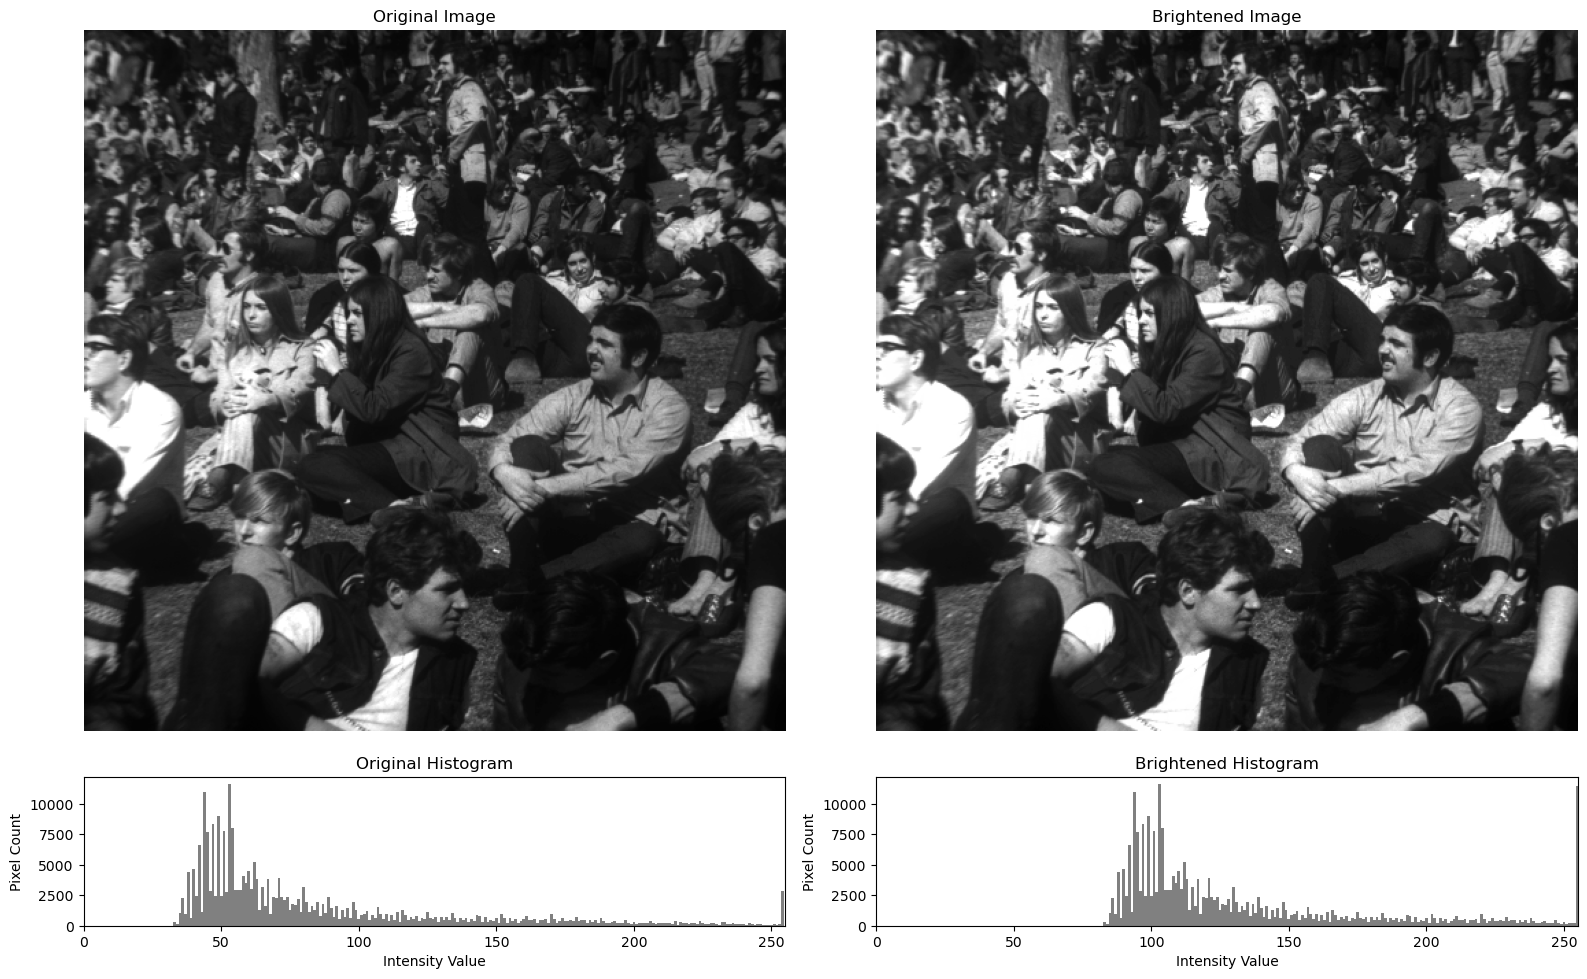

In [16]:
display_image_comparison_with_histogram(image_1=image_2, histogram_1=image_2_histogram, image_2=brightened_image_2, histogram_2=brightened_image_2_histogram, title_1='Original Image',
                                            hist_title_1='Original Histogram', title_2='Brightened Image', hist_title_2='Brightened Histogram')

We can verify that the image produced by histogram matching by generating the histogram of the result image.

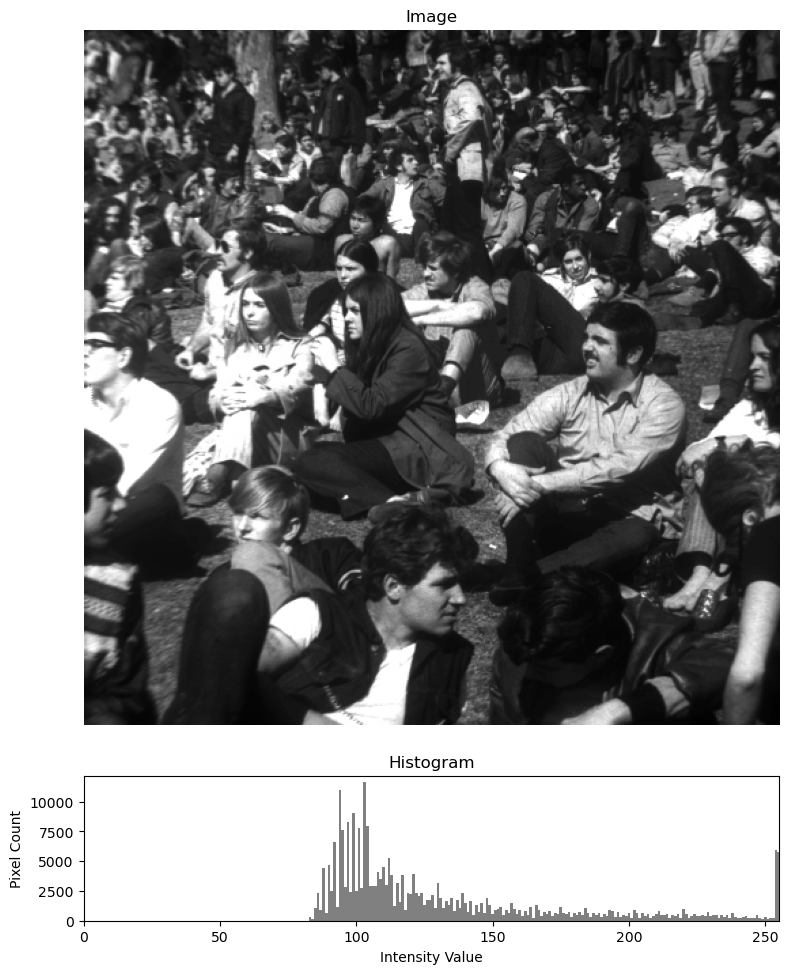

In [17]:
test_brightened_image_2_histogram = apply(brightened_image_2, generate_histogram, return_array=True)
display_image_with_histogram(brightened_image_2, test_brightened_image_2_histogram)

If we observe the two histograms closely we'll notice that there are differences between the histogram we modified and the histogram of the resulatant image. Since the histogram matching algorithm maps the CDF of the original image to the CDF of the target distribution. Even if the CDFs match closely, the bin-by-bin frequencies in the final histogram may differ. This is because multiple original intensities may map to the same new intensity (or vice versa), creating small distortions in the final discrete histogram.

Some of the discrepancy may also be caused by the type conversions being made, since we clip the mapping to `uint8` to produce valid images we do lose some information during that process which may cause a difference in the distributions.

## Histogram Equalization Algorithm

Histogram equalization is a method to adjust the contrast of an image by modifying its histogram so that the resulting image has a more uniform distribution of intensities.

Let:
-  $L$: Number of possible intensity levels
-  $\mathbf{h}[k]$: Count of pixels at intensity $k \in \{0, \dots, L-1\}$
-  $\mathbf{h}_{\text{eq}}$: Equalized histogram

For a histogram $\mathbf{h}$:

1. Compute the cumulative distribution function (CDF) $\mathbf{c}[k]$ of the histogram:
   $$
   \mathbf{c}[k] \;=\; \sum_{i=0}^{k} \mathbf{h}[i], \quad \forall k \in \{0, \dots, L-1\}.
   $$
2. Normalize the CDF $\mathbf{c}_{\text{norm}}(k)$:
   $$
   \mathbf{c}_{\text{norm}}(k) \;=\; \frac{\mathbf{c}[k]}{N},
   $$
   where
   $$
   N \;=\; \sum_{k=0}^{L-1} \mathbf{h}[k]
   $$
3. Define the intensity mapping $T(r)$ for histogram equalization:
   $$
   T(r) \;=\; \left\lfloor (L-1) \cdot \mathbf{c}_{\text{norm}}(r) \right\rfloor, 
   \quad \forall r \in \{0, \dots, L-1\},
   $$
   where $\lfloor \cdot \rfloor$ denotes the floor operation.
4. Compute the equalizes histogram $\mathbf{h}_{\text{eq}}$
   $$
   \mathbf{h}_{\text{eq}}[k] = 
       \begin{cases}
       \sum_{i=0}^{L-1} h[i], & \text{if} \, T(i) = k \\
       0, & \text{otherwise}
       \end{cases}
    \quad \forall k \in \{0, \dots, L-1\}.
   $$

### Implementation

In [18]:
def equalize_histogram(h: np.ndarray) -> np.ndarray:
    L = 256

    c = np.cumsum(h).astype(np.float64)
    c_norm = c / c[-1]

    T = np.zeros(L, dtype=np.uint64)
    for r in range(L):
        T[r] = np.floor((L-1) * c_norm[r])

    h_eq = np.zeros(L, dtype=np.uint64)
    for k in range(L):
        h_eq[k] = np.sum(h[T == k])

    return h_eq

### Examples

#### Example 1

*Using same image from last example*

In [19]:
equalized_image_2_histogram = equalize_histogram(image_2_histogram)
equalized_image_2 = apply(image_2, match_histogram, return_array=False, h=image_2_histogram, h_prime=equalized_image_2_histogram)

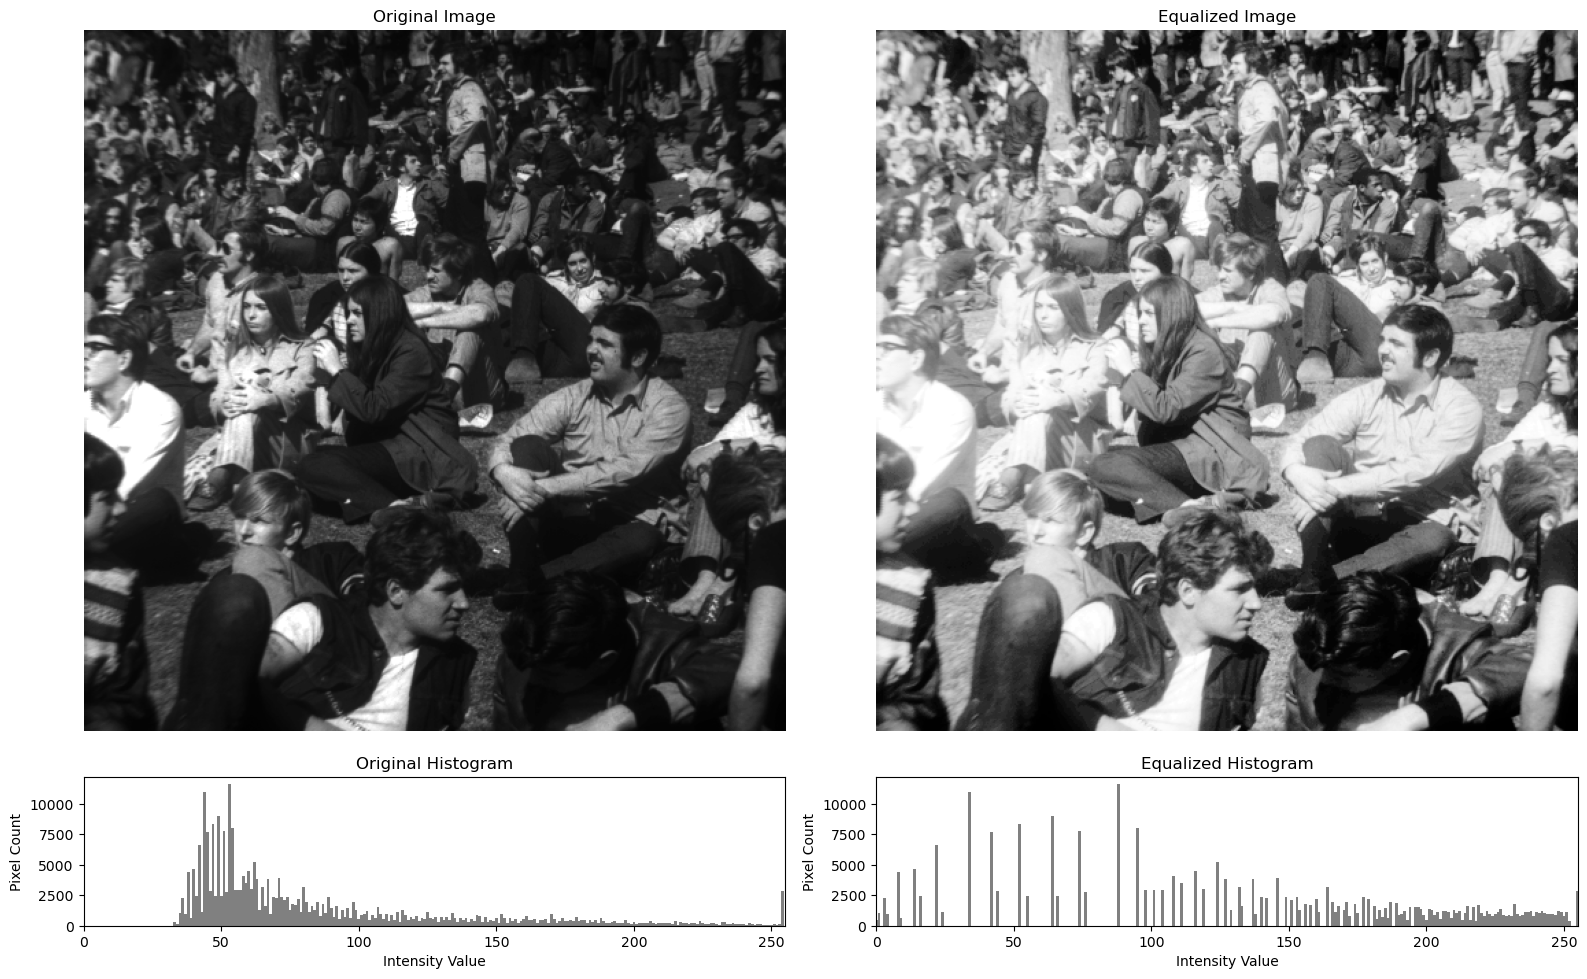

In [20]:
display_image_comparison_with_histogram(image_1=image_2, histogram_1=image_2_histogram, image_2=equalized_image_2, histogram_2=equalized_image_2_histogram, title_1='Original Image',
                                            hist_title_1='Original Histogram', title_2='Equalized Image', hist_title_2='Equalized Histogram')

#### Example 2

In [21]:
image_3_path = "../TEST-IMAGES/OLD-CLASSIC/truck.pgm"
image_3 = load_image(image_3_path)

Image Metadata for 'truck.pgm':
 - Format: PPM
 - Size on Disk: 256.06 KB
 - Dimensions: 512x512 pixels
 - Mode: L
 - Channels: 1


In [22]:
image_3_histogram = apply(image_3, generate_histogram, return_array=True)
equalized_image_3_histogram = equalize_histogram(image_3_histogram)
equalized_image_3 = apply(image_3, match_histogram, return_array=False, h=image_3_histogram, h_prime=equalized_image_3_histogram)

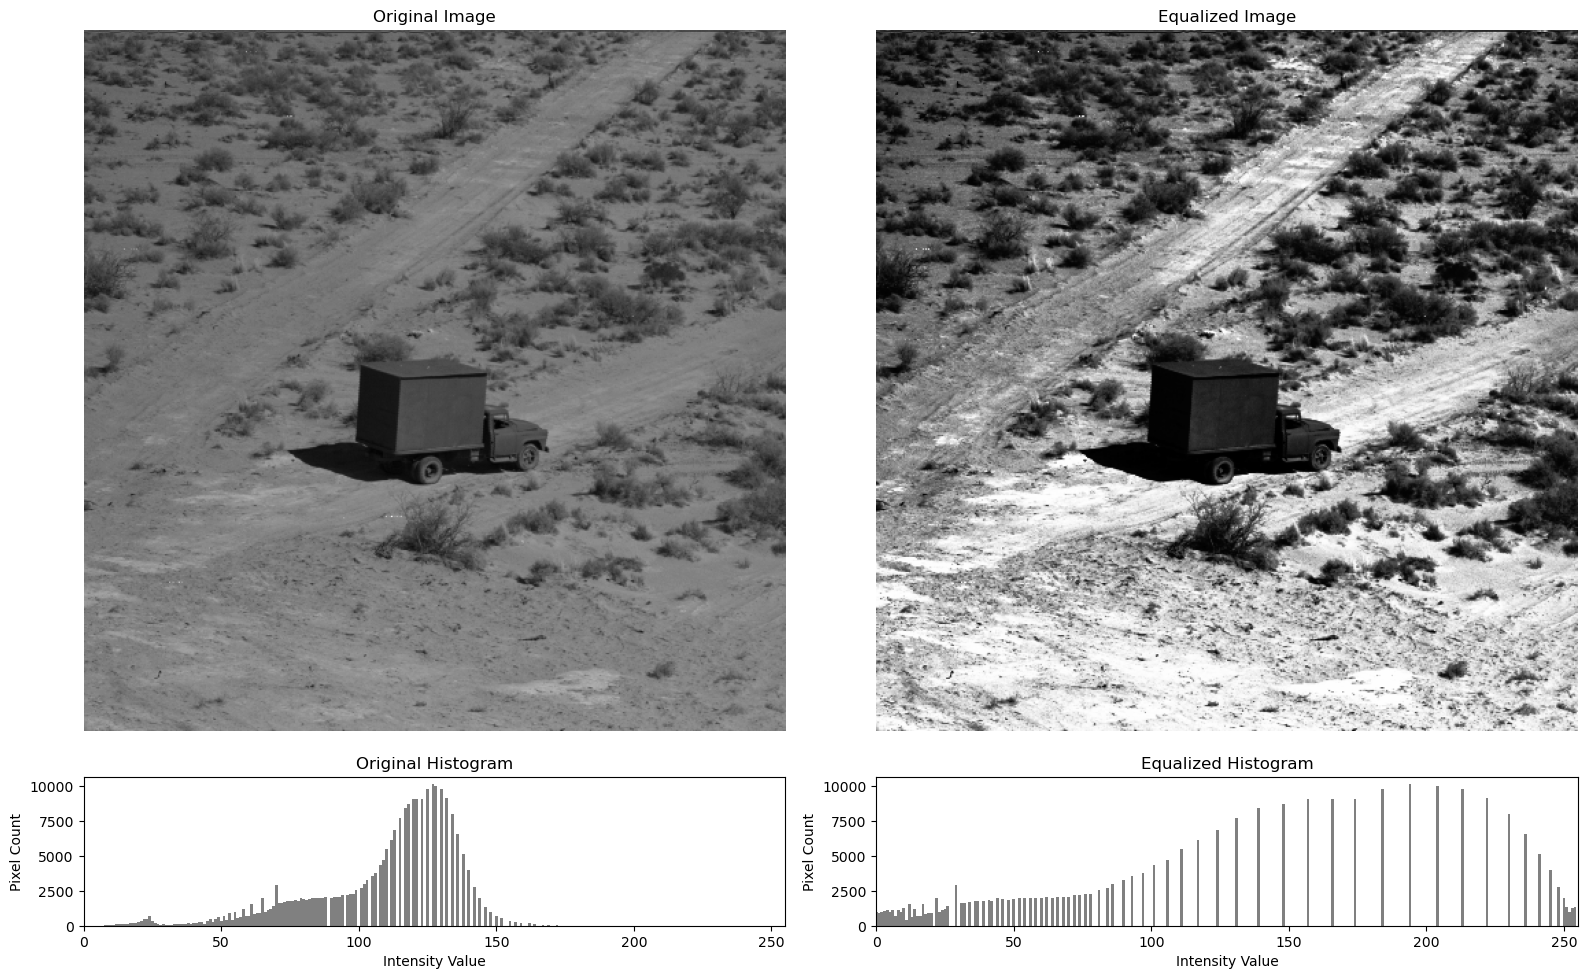

In [23]:
display_image_comparison_with_histogram(image_1=image_3, histogram_1=image_3_histogram, image_2=equalized_image_3, histogram_2=equalized_image_3_histogram, title_1='Original Image',
                                            hist_title_1='Original Histogram', title_2='Equalized Image', hist_title_2='Equalized Histogram')